# **미니프로젝트 4차 1대1 문의 내용 유형 분류기**
# 단계1 : 데이터 탐색

### 문제 정의
> 1:1 문의 내용 분류 문제<br>
> 1. 문의 내용 분석
> 2. 문의 내용 분류 모델 성능 평가
### 학습 데이터
> * 1:1 문의 내용 데이터 : train.csv

### 변수 소개
> * text : 문의 내용
> * label : 문의 유형

### References
> * 한국어 처리
>> * [konlpy - 한국어 처리 라이브러리](https://konlpy.org/ko/latest/)
>> * [한국어 품사 태그 비교표](https://docs.google.com/spreadsheets/d/1OGAjUvalBuX-oZvZ_-9tEfYD2gQe7hTGsgUpiiBSXI8/edit#gid=0)
>> * [한국어 품사 태깅 성능 비교](https://konlpy.org/ko/latest/morph/#comparison-between-pos-tagging-classes)
>> * [한국어 시스템 사전](https://konlpy.org/ko/latest/data/#corpora)

> * 자연어 처리
>> * [NLTK](https://www.nltk.org/book/)
>> * [gensim](https://radimrehurek.com/gensim/)
>> * [Google guide](https://developers.google.com/machine-learning/guides/text-classification/step-2)
>> * [WordCloud](https://amueller.github.io/word_cloud/)

## 1. 개발 환경 설정

* 세부 요구사항
  - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
  - 필요하다고 판단되는 라이브러리를 추가하세요.
  - konlpy, mecab 설치 후 형태소 분석 함수 생성

### 1-1. 라이브러리 설치

In [ ]:
# 필요 라이브러리부터 설치할께요.
# !pip install konlpy pandas seaborn gensim wordcloud python-mecab-ko wget svgling

In [ ]:
# 런타임 재시작 필요
"""
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
"""

'\n!sudo apt-get install -y fonts-nanum\n!sudo fc-cache -fv\n!rm ~/.cache/matplotlib -rf\n'

### 1-2. 라이브러리 import

In [ ]:
from mecab import MeCab
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from wordcloud import WordCloud
from collections import Counter
import wget, os

### 1-3. 한글 글꼴 설정

In [ ]:
FONT_PATH = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = fm.FontProperties(fname=FONT_PATH, size=10).get_name()
print(font_name)
plt.rcParams['font.family']=font_name
assert plt.rcParams['font.family'] == [font_name], "한글 폰트가 설정되지 않았습니다."

NanumGothic


### 1-4. 구글드라이브 연결

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2.데이터 불러오기

### 2-1. 데이터 로딩

* 다음 데이터를 불러옵니다.
    * 학습 및 검증용 데이터 : train.csv
    * shape를 확인합니다.

In [ ]:
path = '/content/drive/MyDrive/에이블/미니프로젝트4차_3~7일차/train.csv'
data = pd.read_csv(path)
data.head()

,text,label
0,"self.convs1 = nn.ModuleList([nn.Conv2d(1, Co, ...",코드2
1,현재 이미지를 여러개 업로드 하기 위해 자바스크립트로 동적으로 폼 여러개 생성하는데...,웹
2,glob.glob(PATH) 를 사용할 때 질문입니다.\n\nPATH에 [ ] 가 ...,코드2
3,"tmpp = tmp.groupby(by = 'Addr1', as_index=Fals...",코드2
4,filename = TEST_IMAGE + str(round(frame_sec)) ...,코드2


In [ ]:
data.shape

(3706, 2)

### 2-2. 데이터 확인하기
* 문의 유형 분포 확인
* data type, 결측치 확인

In [ ]:
# 결측치 확인
data.isnull().sum()

text     0
label    0
dtype: int64

In [ ]:
# data type 확인
data.describe

<bound method NDFrame.describe of                                                    text   label
0     self.convs1 = nn.ModuleList([nn.Conv2d(1, Co, ...     코드2
1     현재 이미지를 여러개 업로드 하기 위해 자바스크립트로 동적으로 폼 여러개 생성하는데...       웹
2     glob.glob(PATH) 를 사용할 때 질문입니다.\n\nPATH에 [ ] 가 ...     코드2
3     tmpp = tmp.groupby(by = 'Addr1', as_index=Fals...     코드2
4     filename = TEST_IMAGE + str(round(frame_sec)) ...     코드2
...                                                 ...     ...
3701  토큰화 이후 train val 를 분리하고 각 train set, val set에 ...     코드2
3702  올린 값들 중 최고점인 건가요? 아니면 최근에 올린 파일로 무조건 갱신인가요?\n최...  시스템 운영
3703  수업에서 cacoo랑 packet tracer를 배우는 이유가\n\n1. IT 인프...      이론
3704  inplace =True 해도 값이 변경이 안되고 none으로 뜹니다. 혹시 원격지...      원격
3705  상관관계는 그렇게 크지 않게 나오는데 p -value 값은 관련이 있게 나오는데 \...      이론

[3706 rows x 2 columns]>

## 3.데이터 탐색하기


### 3-1. 문의 내용 길이 분포

* 문의 내용의 길이 분포를 확인합니다.
* 최소, 최대 길이의 index 및 문의 내용을 확인합니다.

In [ ]:
# text에는 문의 내용, label에는 문의 유형
data.label

0          코드2
1            웹
2          코드2
3          코드2
4          코드2
         ...  
3701       코드2
3702    시스템 운영
3703        이론
3704        원격
3705        이론
Name: label, Length: 3706, dtype: object

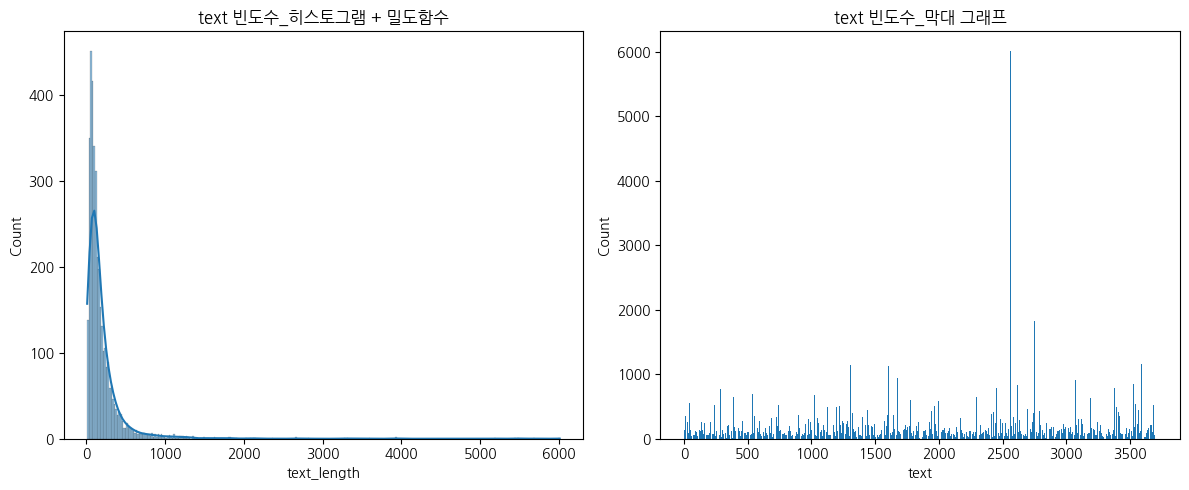

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

data['text_length'] = data['text'].apply(len)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(data['text_length'], kde = True)
plt.title('text 빈도수_히스토그램 + 밀도함수')

# 막대 그래프
plt.subplot(1, 2, 2)
text_lengths = data['text_length']
plt.bar(text_lengths.index, text_lengths)
plt.title('text 빈도수_막대 그래프')
plt.xlabel('text')
plt.ylabel('Count')
plt.tight_layout()  # 그래프들 사이 간격 조절
plt.show()

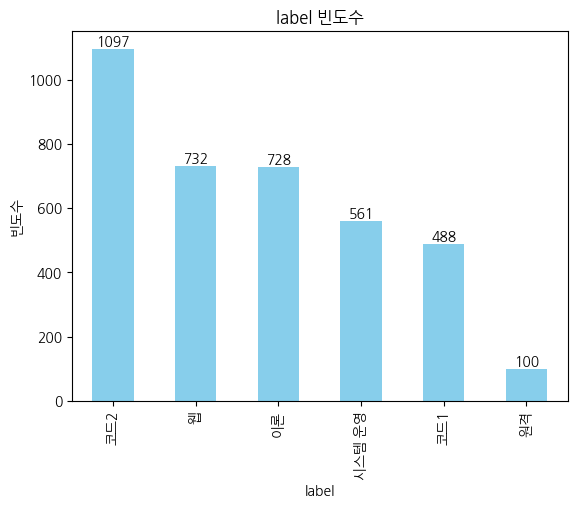

In [ ]:
# 문의 유형(index) 빈도수 그래프
import matplotlib.pyplot as plt
import pandas as pd

label_counts = data['label'].value_counts()
ax = label_counts.plot(kind='bar', color='skyblue')

plt.title('label 빈도수')
plt.xlabel('label')
plt.ylabel('빈도수')

# 막대 위에 값 출력
for i, v in enumerate(label_counts):
    ax.text(i, v + 1, str(v), ha='center', va='bottom', fontsize=10)
plt.show()

In [ ]:
# 최소, 최대 길이의 index 및 문의 내용
shortest_index = data['text_length'].idxmin()
longest_index = data['text_length'].idxmax()

shortest_text = data.loc[shortest_index, 'text']
longest_text = data.loc[longest_index, 'text']

# 결과 출력
print("가장 짧은 길이의 인덱스:",shortest_index)
print("가장 짧은 길이의 문의 내용:", shortest_text)

print("가장 긴 길이의 인덱스:" ,longest_index)
print("가장 긴 길이의 문의 내용:",longest_text)

가장 짧은 길이의 인덱스: 756
가장 짧은 길이의 문의 내용: 원격 부탁드립니다
가장 긴 길이의 인덱스: 2561
가장 긴 길이의 문의 내용: sns.kdeplot(x = td[var])
plt.show()

---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
 in 
----&gt; 1 sns.kdeplot(x = td[var])
      2 plt.show()

~\anaconda3\lib\site-packages\seaborn\_decorators.py in inner_f(*args, **kwargs)
     44             )
     45         kwargs.update({k: arg for k, arg in zip(sig.parameters, args)})
---&gt; 46         return f(**kwargs)
     47     return inner_f
     48 

~\anaconda3\lib\site-packages\seaborn\distributions.py in kdeplot(x, y, shade, vertical, kernel, bw, gridsize, cut, clip, legend, cumulative, shade_lowest, cbar, cbar_ax, cbar_kws, ax, weights, hue, palette, hue_order, hue_norm, multiple, common_norm, common_grid, levels, thresh, bw_method, bw_adjust, log_scale, color, fill, data, data2, warn_singular, **kwargs)
   1768             plot_kws["color"] = color


### 3-2. 명사 추출하고 품사 태깅하기

* konlpy, MeCab을 활용하여 품사 태깅, 명사 추출하기.
* 2개 이상의 형태소 분석기를 Time analysis 해보기
* Number of Samples / Number of words per sample 구해보기

In [ ]:
from konlpy.tag import Kkma, Komoran, Okt, Hannanum #Mecab은 윈도우에서 작동 불가능
from mecab import MeCab
okt = Okt()
kkma = Kkma()
komoran = Komoran()
hannanum = Hannanum()
mecab = MeCab()

text = '나랏말이 중국과 달라 한자와 서로 통하지 아니하므로, \
    우매한 백성들이 말하고 싶은 것이 있어도 마침내 제 뜻을 잘 표현하지 못하는 사람이 많다.\
    내 이를 딱하게 여기어 새로 스물여덟 자를 만들었으니, \
    사람들로 하여금 쉬 익히어 날마다 쓰는 데 편하게 할 뿐이다.'

#### .nouns()함수: 명사를 추출 ####
print("[Kkma nouns 함수]")
print(kkma.nouns(text))
print("[OKt nouns 함수]")
print(okt.nouns(text))
print("[Komoran nouns 함수]")
print(komoran.nouns(text))
print("[Hannanum nouns 함수]")
print(hannanum.nouns(text))
print("----------------\n[MeCab nouns 함수]")
print(mecab.nouns(text))

#### .pos()함수: 품사 태깅 ####
print("----------------\n")
print("[Kkma pos 함수]")
print(kkma.pos(text)) #join=True는 형태소와 품사를 붙여서 리스트화
print("[Okt pos 함수]")
print(okt.pos(text))
print("[Komoran pos 함수]")
print(komoran.pos(text))
print("[Hannanum pos 함수]")
print(hannanum.pos(text))
print("----------------\n[MeCab pos 함수]")
print(mecab.pos(text))

[Kkma nouns 함수]
['나랏말', '중국', '한자', '우매', '백성', '저', '뜻', '표현', '사람', '내', '스물', '스물여덟', '여덟', '자', '로', '날', '데', '뿐']
[OKt nouns 함수]
['나랏말', '중국', '달라', '한자', '서로', '통', '우매', '백성', '말', '것', '마침내', '제', '뜻', '표현', '사람', '내', '스물', '여덟', '사람', '쉬', '날', '데', '뿐']
[Komoran nouns 함수]
['중국', '한자', '우매', '백성', '말', '것', '뜻', '표현', '사람', '자', '사람', '날', '데', '뿐']
[Hannanum nouns 함수]
['나랏말', '중국', '자', '우매', '백성들', '말', '것', '저', '뜻', '표현', '사람', '내', '이', '여기', '스물여덟', '자', '사람들', '데', '뿐']
----------------
[MeCab nouns 함수]
['나', '랏', '말', '중국', '한자', '백성', '말', '것', '뜻', '표현', '사람', '내', '이', '여기', '스물', '여덟', '자', '사람', '날', '데', '뿐']
----------------

[Kkma pos 함수]
[('나랏말', 'UN'), ('이', 'JKS'), ('중국', 'NNG'), ('과', 'JKM'), ('닿', 'VV'), ('ㄹ라', 'ECD'), ('한자', 'NNG'), ('와', 'JKM'), ('서로', 'MAG'), ('통하', 'VV'), ('지', 'ECD'), ('아니하', 'VXV'), ('므로', 'ECD'), (',', 'SP'), ('우매', 'NNG'), ('하', 'XSV'), ('ㄴ', 'ETD'), ('백성', 'NNG'), ('들', 'XSN'), ('이', 'JKS'), ('말하', 'VV'), ('고', 'ECE'), ('싶', 'VX

In [ ]:
from konlpy.tag import Okt
from mecab import MeCab

okt = Okt()
mecab = MeCab()
# pos : 품사 태깅
# nouns : 명사 추출

# 품사 태깅
okt_pos = []
mecab_pos = []
for text in data['text']:
    okt_pos.append(okt.pos(text))
    mecab_pos.append(mecab.pos(text))

data['okt_pos'] = okt_pos
data['mecab_pos'] = mecab_pos

# 명사 추출
okt_nouns = []
mecab_nouns = []
for text in data['text']:
    okt_nouns.append(okt.nouns(text))
    mecab_nouns.append(mecab.nouns(text))

data['okt_nouns'] = okt_nouns
data['mecab_nouns'] = mecab_nouns

# 결과 출력
print(data)

                                                   text   label  text_length  \
0     self.convs1 = nn.ModuleList([nn.Conv2d(1, Co, ...     코드2          144   
1     현재 이미지를 여러개 업로드 하기 위해 자바스크립트로 동적으로 폼 여러개 생성하는데...       웹          119   
2     glob.glob(PATH) 를 사용할 때 질문입니다.\n\nPATH에 [ ] 가 ...     코드2          147   
3     tmpp = tmp.groupby(by = 'Addr1', as_index=Fals...     코드2          279   
4     filename = TEST_IMAGE + str(round(frame_sec)) ...     코드2          144   
...                                                 ...     ...          ...   
3701  토큰화 이후 train val 를 분리하고 각 train set, val set에 ...     코드2          168   
3702  올린 값들 중 최고점인 건가요? 아니면 최근에 올린 파일로 무조건 갱신인가요?\n최...  시스템 운영           75   
3703  수업에서 cacoo랑 packet tracer를 배우는 이유가\n\n1. IT 인프...      이론          915   
3704  inplace =True 해도 값이 변경이 안되고 none으로 뜹니다. 혹시 원격지...      원격           75   
3705  상관관계는 그렇게 크지 않게 나오는데 p -value 값은 관련이 있게 나오는데 \...      이론           69   

                                       

### 3-3. nltk로 텍스트 분석하기
* 3-2.의 명사 추출, 품사 태깅한 데이터를 nltk Text로 변경하기
* 각각 token 갯수 / 전체 token 비율(Type-Token Ratio) 알아보기
* 각각 Frequency 확인 및 분포 시각화
* 명사 추출한 데이터에서 코드, 웹, 이론, 원격, 시스템 등 관심있는 각 단어에 분석해보기
* 각각 collocation 확인
* 최소 길이 문의 내용에 대해 grammar pasing 해보기(아래 코드 활용)


```python
grammar = """
NP: {<N.*>*<Suffix>?}   # Noun phrase
VP: {<V.*>*}            # Verb phrase
AP: {<A.*>*}            # Adjective phrase
"""
NP_grammar = "NP: {<Adjective>*<Noun>*}"
```

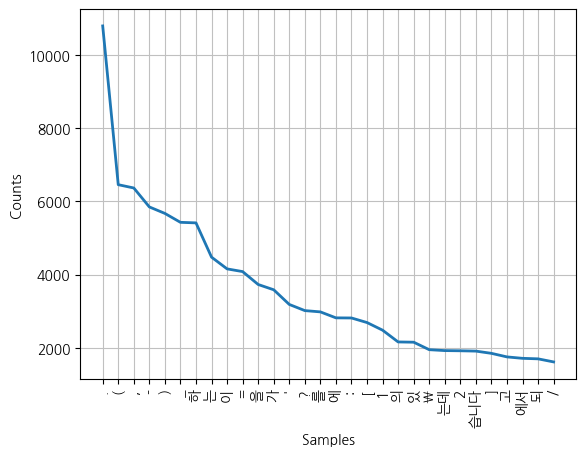

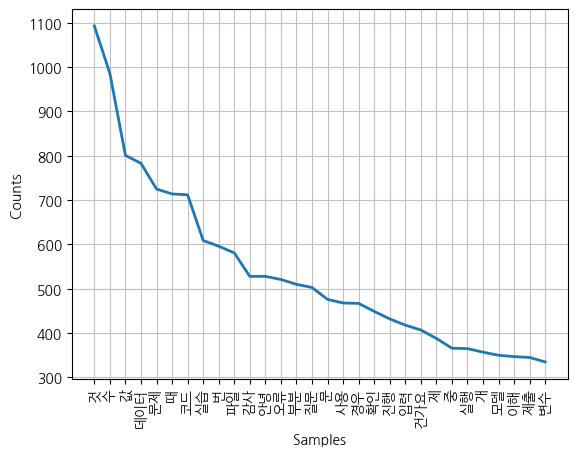

POS Token 개수:  297496
Nouns Token 개수:  57025
전체 Token 개수:  354521
POS TTR: 3.72%
Nouns TTR: 6.00%


In [ ]:
import nltk
from nltk import collocations
import matplotlib.pyplot as plt
import pandas as pd

# 3-2의 명사 추출, 품사 태깅한 데이터를 nltk Text로 변경
pos_words = []
for pos in mecab_pos:
    words = [word for word, tag in pos]
    pos_words += words
pos_text = nltk.Text(pos_words)

nouns_words = []
for nouns in mecab_nouns:
    nouns_words += nouns
nouns_text = nltk.Text(nouns_words)
pos_text.plot(30)
nouns_text.plot(30)

# 각각 token 개수 계산
pos_token_count = len(pos_text)
nouns_token_count = len(nouns_text)

# 전체 token 개수 계산
total_token_count = pos_token_count + nouns_token_count

# Type-Token Ratio (TTR) 계산
ttr_pos = len(set(pos_text)) / pos_token_count
ttr_nouns = len(set(nouns_text)) / nouns_token_count

print("POS Token 개수: ",pos_token_count)
print("Nouns Token 개수: ",nouns_token_count)
print("전체 Token 개수: ",total_token_count)
print("POS TTR: {:.2%}".format(ttr_pos))
print("Nouns TTR: {:.2%}".format(ttr_nouns))


In [ ]:
# grammar pasing
import nltk
from IPython.display import display

grammar = """
NP: {<N.*>*<Suffix>?}   # Noun phrase
VP: {<V.*>*}            # Verb phrase
AP: {<A.*>*}            # Adjective phrase
"""
NP_grammar = "NP: {<Adjective>*<Noun>*}"

parser_ko = nltk.RegexpParser(grammar)
chunks_ko = parser_kp.parse(pos_tuple[train_df.text.str.len().argmin()])
display(chunks_ko)

NameError: ignored

### 3-4. Wordcloud 만들기
* 명사 추출/형태소 분석 결과를 이용하여 WordCloud 객체를 생성
* 최대 글꼴 크기(max_font_size), 최대 단어 수(max_words), 배경 색상(background_color)
* 상대 크기비율(relative_scaling), 그림 크기(width, height), 폰트 경로(font_path=FONT_PATH) 등 설정
* .generate 메서드를 연결하여 WordCloud에 사용될 텍스트 데이터 생성
* plt.imshow(  ) 를 통해 화면에 보여집니다.

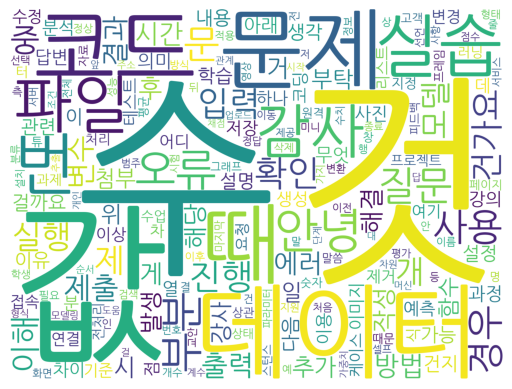

In [ ]:
wc = WordCloud(width=2000, height=1500, background_color="white", font_path = FONT_PATH, random_state=0)
plt.imshow(wc.generate_from_frequencies(nouns_text.vocab()))
plt.axis("off")
plt.show()

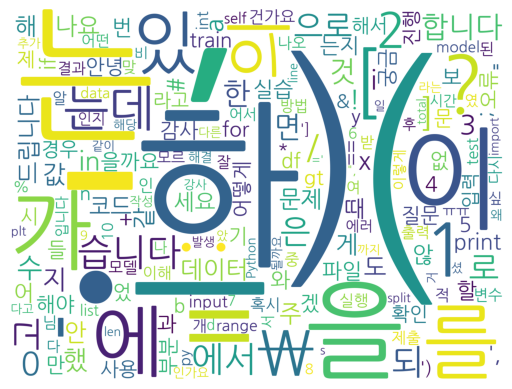

In [ ]:
wc = WordCloud(width=2000, height=1500, background_color="white", font_path = FONT_PATH, random_state=0)
plt.imshow(wc.generate_from_frequencies(pos_text.vocab()))
plt.axis("off")
plt.show()

## 4. 문의 유형에 따른 분석
### 4-1. *3. 데이터 탐색*에서 실행한 알고리즘을 문의 유형에 따라 실행할 수 있는 함수를 개발합니다.
* 아래 text_analysis 함수를 개발합니다.

In [ ]:
def text_analysis(df, label=None):
    """
    label에 따라서 분석, label이 None인 경우 전체 분석
    데이터 확인, 데이터 길이 시각화
    명사 추출하여 분석, 워드 클라우드 시각화

    Parameters
    ----------
    df : pandas DataFrame object.
    label : Label for analysis, default=None.
    - If label is None, Entire data are analyzed.

    Returns
    -------
    result : None

    """
    pass

### 4-2. 각각의 문의 유형에 대해 실행합니다.

In [ ]:
for label in sorted(train_df.label.unique()):
    text_analysis(train_df,label)

# 단계2 : 데이터 전처리
> * Tokenization(Konlpy...)
> * Vectorization(N-grams, Sequence)
> * [Google guide](https://developers.google.com/machine-learning/guides/text-classification/step-3)

## 5. 데이터 준비

### 5-1. label 아래 형식으로 처리

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [ ]:
label_dict = {
    '코드1': 0,
    '코드2': 0,
    '웹': 1,
    '이론': 2,
    '시스템 운영': 3,
    '원격': 4
}
preprocessed_df = data.replace({'label': label_dict}).copy()

### 5-2. Train Validation split

In [59]:
# processed_df 데이터를 train, valid, test로 데이터 분할
X_tr, X_val, Y_tr, Y_val = train_test_split(preprocessed_df.text, preprocessed_df.label, test_size=0.15, random_state=42)
X_tr, X_te, Y_tr, Y_te = train_test_split(X_tr, Y_tr, test_size=0.15, random_state=42)

## 6. 데이터 처리

### 6-1. 특수문자 제거(Optional)
- [정규표현식 이용](https://docs.python.org/3/howto/regex.html)

In [55]:
import re
import string

removal_list = "'/\?~`!|<>{}" # 제거할 특수문자
removal_list += string.punctuation
def cleansing_special(sentence: str = None) -> str:
    sentence = re.sub("[^가-힣0-9a-zA-Z\\s]", " ", sentence)
    sentence = re.sub("\s+", " ", sentence)
    sentence = sentence.translate(str.maketrans(removal_list, ' '*len(removal_list)))
    sentence = sentence.strip()
    return sentence

for idx, row in preprocessed_df.iterrows():
    sent = row['text']
    if idx < 5:
        print(f"===== {idx} =====")
        print(f"전처리 전 : {sent}")
        print(f"전처리 후 : {cleansing_special(sent)}")

===== 0 =====
전처리 전 : self.convs1 = nn.ModuleList([nn.Conv2d(1, Co, (K, 100)) for K in Ks])
1. 여기서 커널사이즈 K,100 은 한 단어의 최대 길이가 100이 넘지않는다는 가정으로 그냥 100으로 선언한 것인지 궁금합니다.
전처리 후 : self convs1 nn ModuleList nn Conv2d 1 Co K 100 for K in Ks 1 여기서 커널사이즈 K 100 은 한 단어의 최대 길이가 100이 넘지않는다는 가정으로 그냥 100으로 선언한 것인지 궁금합니다
===== 1 =====
전처리 전 : 현재 이미지를 여러개 업로드 하기 위해 자바스크립트로 동적으로 폼 여러개 생성하는데 클릭해도 생성이 안되네요... 막혀서 뭘 할 수가 없네요.. 혹시나 해서 기본 예제코드로만 간단히 돌려도 안됩니다. 이유가 뭘까요
전처리 후 : 현재 이미지를 여러개 업로드 하기 위해 자바스크립트로 동적으로 폼 여러개 생성하는데 클릭해도 생성이 안되네요 막혀서 뭘 할 수가 없네요 혹시나 해서 기본 예제코드로만 간단히 돌려도 안됩니다 이유가 뭘까요
===== 2 =====
전처리 전 : glob.glob(PATH) 를 사용할 때 질문입니다.

PATH에 [ ] 가 포함되면 제대로 작동하지 않는 것 같아 질문 드립니다.

제공해주신 파일에 AIVLE_3rd[Team] 폴더가 포함되어 있는데, 이 폴더 안에는 glob이 정상적으로 작동하지 않습니다.
전처리 후 : glob glob PATH 를 사용할 때 질문입니다 PATH에 가 포함되면 제대로 작동하지 않는 것 같아 질문 드립니다 제공해주신 파일에 AIVLE 3rd Team 폴더가 포함되어 있는데 이 폴더 안에는 glob이 정상적으로 작동하지 않습니다
===== 3 =====
전처리 전 : tmpp = tmp.groupby(by = 'Addr1', as_index=False)[['Category']].sum()


plt.figure(figsize=(15

### 6-2. N-grams (sklearn)
> * [scikit-learn working with text data](https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html#)
> * [scikit-learn text feature extraction](https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)
> * [한글 자료](https://datascienceschool.net/03%20machine%20learning/03.01.03%20Scikit-Learn%EC%9D%98%20%EB%AC%B8%EC%84%9C%20%EC%A0%84%EC%B2%98%EB%A6%AC%20%EA%B8%B0%EB%8A%A5.html)

In [56]:
mecab = MeCab()

def mecab_tokenizer(text):
    node = mecab.pos(text)
    words = []
    for line in node:
        words.append(line[0]+'/'+line[1])
    # moon = ' '.join(words)
    return words

count_vectorizer = CountVectorizer()
# CountVectorizer - 각 문서에 어떤 단어가 몇 번 등장했는지를 파악할 때 사용
#                 - 기본적인 토큰화 방법 :  텍스트를 공백을 기준으로 나눔 - 영어에 특화됨
count_mecab_vectorizer = CountVectorizer(tokenizer = mecab_tokenizer)
# 정교한 토큰화를 위해 MeCab을 사용

x_tr_counts = count_vectorizer.fit_transform(X_tr) # fit_transform은 train데이터에서만 사용
x_val_counts = count_vectorizer.transform(X_val)
x_te_counts = count_vectorizer.transform(X_te)

x_tr_mecab_counts = count_mecab_vectorizer.fit_transform(X_tr)
x_val_mecab_counts = count_mecab_vectorizer.transform(X_val)
x_te_mecab_counts = count_mecab_vectorizer.transform(X_te)

transformer = TfidfTransformer()
x_tr_tfidf = transformer.fit_transform(x_tr_mecab_counts)
x_val_tfidf = transformer.transform(x_val_mecab_counts)
x_te_tfidf = transformer.transform(x_te_mecab_counts)

tfidf_vectorizer = TfidfVectorizer(tokenizer = mecab_tokenizer)
x_tr_tfidfv = tfidf_vectorizer.fit_transform(X_tr)
x_val_tfidfv = tfidf_vectorizer.transform(X_val)
x_te_tfidfv = tfidf_vectorizer.transform(X_te)

print("Count Vectorizer Vocabulary size : ", len(count_vectorizer.vocabulary_))
print("Count Vectorizer(Mecab tokenizer) Vocabulary size : ", len(count_mecab_vectorizer.vocabulary_))
print("TF-IDF Vectorizer(Mecab tokenizer) Vocabulary size : ", len(tfidf_vectorizer.vocabulary_))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Count Vectorizer Vocabulary size :  20613
Count Vectorizer(Mecab tokenizer) Vocabulary size :  9013
TF-IDF Vectorizer(Mecab tokenizer) Vocabulary size :  9013


In [57]:
x_tr_tfidf.toarray()[2,2]

0.0

In [58]:
x_tr_tfidfv.toarray()[2,2]

0.0

In [ ]:
x_tr_tfidf.toarray()[2,2] == x_tr_tfidfv.toarray()[2,2]

True

In [ ]:
(x_tr_tfidf - x_tr_tfidfv).nnz

66481

In [ ]:
np.isclose(x_tr_tfidf.toarray(), x_tr_tfidfv.toarray()).all()

True

### 6-3. Sequence (keras, whatever)
> * [keras text classification](https://keras.io/examples/nlp/text_classification_from_scratch/)
> * [tensorflow text classification](https://www.tensorflow.org/tutorials/keras/text_classification)
* tokenizer.fit_on_texts() : 주어진 텍스트 데이터에 대해 단어 사전 생성
* 문장 길이 분포 살펴보기
* 문장 길이를 구해서 기초통계량, histogram, boxplot을 그려보고 적절한 개수를 결정합니다.
* tokenizer.texts_to_sequences() : 주어진 텍스트 데이터를 정수 시퀀스로 변환

In [ ]:
%%time
import tensorflow as tf
import numpy as np
import tensorflow.keras as keras
from keras.preprocessing import sequence
from keras.preprocessing import text
TOP_K = 5000
MAX_SEQUENCE_LENGTH = 500
X_mor_tr_str = X_tr.apply(lambda x:' '.join(mecab_tokenizer(x)))
X_mor_val_str = X_val.apply(lambda x:' '.join(mecab_tokenizer(x)))
X_mor_te_str = X_te.apply(lambda x:' '.join(mecab_tokenizer(x)))
X_mor_tr = X_tr.apply(lambda x:mecab_tokenizer(x))
X_mor_val = X_val. apply(lambda x: mecab_tokenizer(x))
X_mor_te = X_te. apply(lambda x:mecab_tokenizer(x))

CPU times: user 20.2 s, sys: 413 ms, total: 20.7 s
Wall time: 24.5 s


,count,mean,std,min,25%,50%,75%,max
text,2677.0,79.150542,102.697697,4.0,30.0,52.0,91.0,1553.0


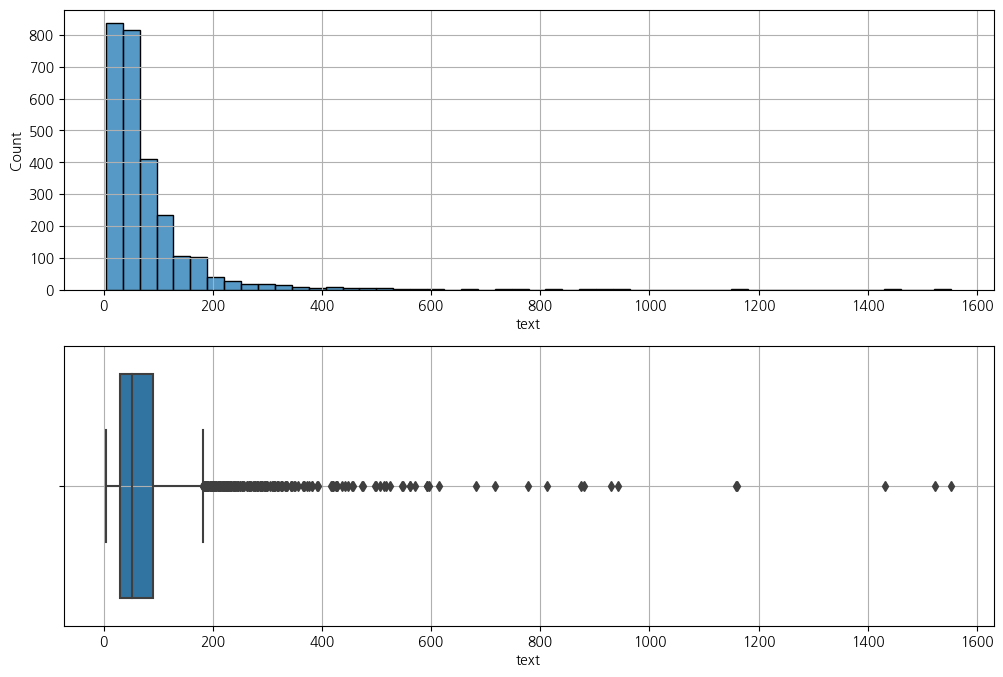

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

train_word_counts = X_mor_tr.apply(lambda x: len(x))
# 통계 정보 출력
display(pd.DataFrame(train_word_counts).describe().T)

plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
sns.histplot(train_word_counts, bins=50)
plt.grid()
plt.subplot(2, 1, 2)
sns.boxplot(x=train_word_counts)
plt.grid()
plt.show()

In [ ]:
tokenizer_str = text.Tokenizer(num_words=TOP_K, char_level=False)
tokenizer_str.fit_on_texts(X_mor_tr_str)
X_mor_tr_seq_str = tokenizer_str. texts_to_sequences (X_mor_tr_str)
X_mor_val_seq_str = tokenizer_str.texts_to_sequences(X_mor_val_str)
X_mor_te_seq_str = tokenizer_str. texts_to_sequences(X_mor_te_str)

max_length = len(max(X_mor_tr_seq_str, key=len))
if max_length > MAX_SEQUENCE_LENGTH:
  max_length = MAX_SEQUENCE_LENGTH

print (max_length)
X_mor_tr_seq_str = sequence.pad_sequences(X_mor_tr_seq_str, maxlen=max_length)
X_mor_val_seq_str = sequence.pad_sequences(X_mor_val_seq_str, maxlen=max_length)
X_mor_te_seq_str = sequence.pad_sequences(X_mor_te_seq_str, maxlen=max_length)

500


In [ ]:
tokenizer = text. Tokenizer(num_words=TOP_K, char_level=False)
tokenizer.fit_on_texts(X_mor_tr)
X_mor_tr_seq = tokenizer. texts_to_sequences(X_mor_tr)
X_mor_val_seg = tokenizer.texts_to_sequences(X_mor_val)
X_mor_te_seq = tokenizer. texts_to_sequences(X_mor_te)

max_length = len(max(X_mor_tr_seq, key=len))
if max_length > MAX_SEQUENCE_LENGTH:
  max_length = MAX_SEQUENCE_LENGTH
print (max_length)
X_mor_tr_seq = sequence. pad_sequences(X_mor_tr_seq, maxlen=max_length)
X_mor_val_seq = sequence. pad_sequences(X_mor_val_seq, maxlen=max_length)
X_mor_te_seq = sequence. pad_sequences(X_mor_te_seq, maxlen=max_length)

500


### 6-4. Word2Vec (gensim, optional)
> * [gensim-word2vec-tutorial](https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html#sphx-glr-auto-examples-tutorials-run-word2vec-py)
> * [tensorflow-word2vec-tutorial](https://www.tensorflow.org/tutorials/text/word2vec?hl=ko)

In [ ]:
from gensim.models import Word2Vec, FastText, KeyedVectors
import logging
logging. basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
SIZE = 128 # embedding_size
WINDOW = 3
MIN_COUNT = 1
w2v_model = Word2Vec(sentences=X_mor_tr,
                     vector_size=SIZE,
                     window=WINDOW,
                     max_vocab_size = None,
                     min_count=MIN_COUNT,
                     workers=4,
                     epochs=10,
                     negative=5,
                     sg=0)

In [ ]:
# 아래 함수는 제공합니다.
def get_sent_embeddings(model, embedding_size, tokenized_words):

    # 단어 임베딩 및 n_words의 크기가 0인 feature_vec 배열을 0으로 초기화합니다.
    # 또한 model.wv.index2word를 사용하여 Word2Vec 모델의 어휘에 단어 세트를 생성합니다.
    feature_vec = np.zeros((embedding_size,), dtype='float32')
    n_words = 0
    index2word_set = set(model.wv.index_to_key)

    # 토큰화된 문장의 각 단어를 반복하고 Word2Vec 모델의 어휘에 존재하는지 확인합니다.
    # 그렇다면 n_words가 증가하고 단어의 임베딩이 feature_vec에 추가됩니다.
    for word in tokenized_words:
        if word in index2word_set:
            n_words += 1
            feature_vec = np.add(feature_vec, model.wv[word])

    # Word2Vec 모델의 어휘에 있는 입력 문장에 단어가 있는지 확인합니다.
    # 있다면 feature_vec를 n_words로 나누어 입력 문장의 평균 임베딩을 구합니다.
    if (n_words > 0):
        feature_vec = np.divide(feature_vec, n_words)

    return feature_vec
def get_dataset(sentences, model, num_features):

    # 각 문장에 대한 임베딩을 보유할 dataset이라는 빈 목록을 초기화합니다.
    dataset = list()

    # 문장의 각 문장을 반복하고 앞에서 설명한 get_sent_embeddings() 함수를 사용하여 문장에 대한 평균 임베딩을 생성합니다.
    # 결과 문장 임베딩이 데이터 세트 목록에 추가됩니다.
    for sent in sentences:
        dataset.append(get_sent_embeddings(model, num_features, sent))

    # 루프에서 생성된 문장 임베딩을 sent_embedding_vectors라는 2차원 배열에 쌓습니다.
    sent_embedding_vectors = np.stack(dataset)

    return sent_embedding_vectors

### 6-5. 데이터 저장하기
* N-gram, Sequence로 처리한 데이터 저장
* sparse data에 대해서는 scipy.sparse.save_npz 활용

In [53]:
import os
import numpy as np
import scipy.sparse

home_directory = os.path.expanduser('/content/drive/MyDrive/에이블/미니프로젝트4차_3~7일차/')
p = os.path.join(home_directory, '')

print('X_train tfidf shape : ', x_tr_tfidf.shape)
print('X_val tfidf shape : ', x_val_tfidf.shape)
print('X_te tfidf shape : ', x_te_tfidf.shape)

scipy.sparse.save_npz(p+'X_tfidf_train', x_tr_tfidf)
scipy.sparse.save_npz(p+'X_tfidf_val.npz', x_val_tfidf)
scipy.sparse.save_npz(p+'X_tfidf_te.npz', x_te_tfidf)

print('X_mor_train seq shape : ', X_mor_tr_seq.shape)
print('X_mor_val seq shape : ', X_mor_val_seq.shape)
print('X_mor_te seq shape : ', X_mor_te_seq.shape)
np.save(p+'X_mor_sequence_train.npy', arr = X_mor_tr_seq)
np.save(p+'X_mor_sequence_val.npy', arr = X_mor_val_seq)
np.save(p+'X_mor_sequence_te.npy', arr = X_mor_te_seq)

print(p+'y_train shape : ', Y_tr.shape)
print(p+'y_val shape : ', Y_val.shape)
np.save(p+'y_train.npy', arr = Y_tr)
np.save(p+'y_val.npy', arr = Y_val)

X_train tfidf shape :  (2677, 9690)
X_val tfidf shape :  (556, 9690)
X_te tfidf shape :  (473, 9690)
X_mor_train seq shape :  (2677, 500)
X_mor_val seq shape :  (556, 500)
X_mor_te seq shape :  (473, 500)
/content/drive/MyDrive/에이블/미니프로젝트4차_3~7일차/y_train shape :  (2677,)
/content/drive/MyDrive/에이블/미니프로젝트4차_3~7일차/y_val shape :  (556,)
